In [ ]:
# The code was removed by Watson Studio for sharing.

# Buying a house in Stockholm

_April 2020_

In [ ]:
#install Libraries
#libraries for scraping data from the web
!conda install -c anaconda beautifulsoup4 -y 
!conda install -c anaconda lxml -y 
!conda install -c conda-forge geocoder --yes
!conda install -c conda-forge geopy --yes
!conda install -c conda-forge folium=0.5.0 --yes
!conda install -c districtdatalabs yellowbrick yes
print('Libraries imported.')

In [ ]:
#import libraries
import pandas as pd

import matplotlib.pyplot as plt

import numpy as np

import seaborn as sns

import bs4 as bs
from bs4 import BeautifulSoup

import requests 

import sys #getsize

import geocoder # import geocoder
import json # library to handle JSON files

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim

import folium # map rendering library

In [ ]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


## References

[1] https://en.wikipedia.org/wiki/Stockholm

[2] https://www.thenewbieguide.se/

[3] https://worldpopulationreview.com/world-cities/stockholm-population/

[4] https://tradingeconomics.com/sweden/interest-rate

[5] https://data.opendatasoft.com

[6] https://geo.nyu.edu

[7] https://www.maklarstatistik.se/omrade/riket/stockholms-lan/



## 1. Introduction

This work has been done as part of the course _IBM Data Science Professional Certificate_ from the platform [Coursera](https://www.coursera.org/professional-certificates/ibm-data-science). 

_All the data and assumptions are from the period before the Covid-19 outbreak. Making different assumption at this stage I believe being premature._



### 1.1 Background.
Stockholm is the capital of Sweden. Almost a million of people lives in the municipality, and approximately 2.4 million in the metropolitan area.
One of the beauties of the city is in its island: the city stretches on 14 island distributed at the intersection of the Lake Mälaren with the Baltic Sea.

Stockholm is the cultural, political, and economic center of Sweden. The city is multicultural, with many national and international corporate headquarters and startups, international students coming from all over the world to attend lectures in its prestigious universities.
It also hosts the annual Nobel Prize ceremonies and banquet at the Stockholm Concert Hall and Stockholm City Hall. 
Art is everywhere, including in the metro stations: the Stockholm metro has been called the longest art gallery in the world. Palaces, Castles, Museums and art galleries are just part of the beauty of the city can offer.
The city also has large parks and green areas, gardens, forests, beaches... a great place to enjoy outdoor life in the summer season.

_Sounds like a great place to relocate, isn't it?_

Stockholm's population is slowly but steadily increasing of more than 1% every year, making it harder and harder to find a place for living since not enough houses are built to keep up with the request (in 2018 around 14000 new dwelling were built, doubling the number of 2010).
This make rental highly competitive. For each ad, it is common that more than 100 people are messaging to get it and usually the places are rented out after just few days.
The research is strenuous, it can take up to several months to get a house to rent and often you have to move out in less than a year. 
If you are lucky, you can rent for as long as two years, facing after two year an increase in price of average 2% on the same type of rental, and it is not uncommon that at least 30 % of one's salary goes into the rent.



To stop living on the edge and finally settle, buying a house in Stockholm can be a solution.

Buying a house in Stockholm can be the best option for a variety of reasons:
- By the Swedish law, one needs to have a minimum 15% of the apartment value. It is possible to get mortgages quite easily if you have a fulltime job. In many cases, paying the mortgage is less expensive than paying a rent. Sweden has also one of the world’s lowest interest rate (-0.25%, 1019) 
- On average, the values of apartment in Stockholm is increasing. In the last 20 years, the increment has been around 60%.
- One does not need to move out suddenly or after a short period.

### 1.2 Where is the best place to buy a house in Stockholm?

What can be good parameters to decide where to buy a house in Stockholm?

- price and possible profit when you sell it,
- location,
- amenities,
- proximity to nature, beaches, ...
- schools,
- criminality rate, 
- initial investment one can do,
- size,
- proximity to work or other favorite places,
- proximity to public transportation,
- ...

There are many different and preferred parameters for each one of us and it is out of the scope of this work to evaluate all of them. However, this work want to be a first skimming to look further into one's dream house in Stockholm.
In this work, the analysis will include all the so-called Stockholm Län, including also the communes that are not Stockholm anymore but that are in close proximity to it.
In the next section, the parameters taken into consideration are introduced.




## 2. Data acquisition and cleaning.

In this work, Stockholm will be divided in several district plus all the area in the Stockholm Län will be considered. A list of the districts can be found on [Wikipedia](https://en.wikipedia.org/wiki/Category:Districts_of_Stockholm), however the division will be made differently, accordingly to the division in the prices database.
A list with the association district - longitude - latitude - postal code can be found on a different [database](https://data.opendatasoft.com/explore/dataset/geonames-postal-code%40public-us/table/?sort=place_name&q=Stockholm&refine.country_code=SE). This last database is ordered by post code, which are several for each area. To make it more useful to our scopes, i.e. access coordinates for each area, places with different post code but same name will be unified. 
For what concern Stockholm's neighborhood instead, a manual insertion of the coordinates is required since these data are missing.

The coordinates are essential to use the Foursquare API. It can be used to get the most common venues of a given area, including restaurants, parks, nightlife and some metro stations. The Second-level Administrative Divisions of Sweden can be found on the [Spatial Data Repository of NYU](https://geo.nyu.edu/catalog/stanford-vj304zk6062).
That is .json file has coordinates of the all district in Sweden so it needs to be reduced to only to Stockholm Län. Stockholm city can not be divided in departments on the map, since I could not find an adequate .json file.

The list of the prices of the houses per sqm and the comparison of the price in the last 12 months can be found for both the [Län](https://www.maklarstatistik.se/omrade/riket/stockholms-lan/#/bostadsratter/tabell) and for the inner [Stockholm](https://www.maklarstatistik.se/omrade/riket/stockholms-lan/stockholm/#/bostadsratter/tabell).

Finally, as last piece of the puzzle, the last indication will include if the neighborhood is safe or not. To be clear, Stockholm and most of the Län are very safe, but recently some are have been indicated as vulnerable, especially vulnerable and at risk. The data are taken from [Wikipedia](https://en.m.wikipedia.org/wiki/Vulnerable_area) concerning the evaluation of 2019. This data will be integrated in the previous data as boolean variables, where 1 indicate the presence of any of this area.

### 2.1 Importing the data from .cvs files.
The data of the database containing (1) the coordinates and the district is a .cvs file. In this section, the data will be imported and cleaned, as described above.
The data concerning the prices (2) are also .cvs file that can be imported. This file contains several data, but for our purposes, only the cost (Swedish Krona) per square meter is included, in the last three months and in the last year. An additional column to show the difference in price among the two will be added and the data printed.
At this point, it is necessary to unify the two data frames, so it will be necessary to match the areas considered in (1), with the ones considered in (2).
Let's start with the data from (1).

In [ ]:
# The code was removed by Watson Studio for sharing.

In [12]:
df_postal.head()

,place name,Area,Latitude,Longitude
0,Vallentuna,Vallentuna,59.5344,18.0776
1,Akersberga,Osteraker,59.4794,18.2997
2,Akersberga,Osteraker,59.4794,18.2997
3,Akersberga,Osteraker,59.4794,18.2997
4,Akersberga,Osteraker,59.4794,18.2997


In [13]:
df_postal.tail()

,place name,Area,Latitude,Longitude
3452,Kungsangen,Kungsangen,59.4786,17.7483
3453,Kungsangen,Kungsangen,59.4786,17.7483
3454,Bro,Bro,59.5167,17.6333
3455,Stockholm-arlanda,Stockholm-arlanda,59.6352,17.9125
3456,Stockholm-Arlanda,Stockholm-arlanda,59.6352,17.9125


In the tables, the first 5 rows and the last 5 rows of the dataframe are presented.
From this dataframe, the interesting columns are the one temporarily called "admin name2", "latitude","longitude".
There are several refinement of the data necessary:
- if a cell has a "admin name2" not assigned, then the "admin name2" needs to be the same of the "place name";
- the non necessary columns can be removed;
- the three remaining columns need to be renamed as "Area", "Latitude", "Longitude";
- the cells in "Area" have to have only the first letter capitalized.
Let's print the last 5 rows again, to show that the corrections have been made.

In [ ]:
#If a cell has a place name but not kommun 
df_postal.loc[df_postal['admin name2'].isnull(), 'admin name2'] =df_postal['place name']
df_postal.drop(['country code','postal code','admin name1','admin code1',  'admin code2', 'admin name3', 'admin code3','accuracy','coordinates'], axis=1, inplace=True)
df_postal.rename(columns={'admin name2':'Area','latitude':'Latitude','longitude':'Longitude'},inplace=True)
df_postal['Area'] = df_postal['Area'].str.capitalize() 

In [14]:
df_postal.drop(['place name'], axis=1, inplace=True)
df_postal.tail()

,Area,Latitude,Longitude
3452,Kungsangen,59.4786,17.7483
3453,Kungsangen,59.4786,17.7483
3454,Bro,59.5167,17.6333
3455,Stockholm-arlanda,59.6352,17.9125
3456,Stockholm-arlanda,59.6352,17.9125


At this point, the value in "Area" that are the same are grouped and the values of latitude and longitude are averaged. The limit of Latitude and Longitude is to 4 decimals as the value we had precedently.
Finally, the size of the dataframe and a snippet of the dataframe are printed.

In [28]:
df_postal_gr= df_postal.groupby(['Area']).mean()
df_postal_gr= df_postal_gr.round({'Latitude': 4, 'Longitude': 4})
print('The size of this array is ', df_postal_gr.shape)
df_postal_gr.rename(index={'Stockholm': 'Central Stockholm'}, inplace=True)
df_postal_gr.head()

The size of this array is  (61, 2)


,Latitude,Longitude
Area,,
Akersberga,59.4794,18.2997
Alta,59.2667,18.1833
Alvsjo,59.2793,18.0111
Bandhagen,59.2968,18.0313
Botkyrka,59.2168,17.8268


Now the data from (2) can be imported as well and the first 5 rows of both dataframe are shown.

In [ ]:
# @hidden cell
body = client_b869b1d93be342248ecc3b8a08a6c53a.get_object(Bucket='capstoneproject-donotdelete-pr-dvutwshvkmk6mk',Key='stockholm.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

In [15]:
df_sthlm = pd.read_csv("stockholm.csv")
df_sthlm.head()

,areas,Numberofsold,/Sq.m,Averagepricekr,Pricetrends(%),Numberofsold.1,/Sq.m.1,Averagepricekr.1,Pricetrends(%).1
0,Stockholm,4939,74690,4412000,2.4,22317,71827,4272000,9.5
1,Central Stockholm,2535,93787,5553000,3.0,11372,90158,5345000,8.4
2,Bromma,384,58832,3525000,5.0,1800,56586,3421000,7.3
3,Skarholmen,303,47576,3019000,5.9,1252,45212,2932000,6.3
4,Skarpnack,526,59718,3387000,3.2,2319,57861,3270000,8.4


In [ ]:
# @hidden cell
body = client_b869b1d93be342248ecc3b8a08a6c53a.get_object(Bucket='capstoneproject-donotdelete-pr-dvutwshvkmk6mk',Key='Stockholmslan.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

In [16]:
df_sthlm_lan= pd.read_csv("Stockholmslan.csv")
df_sthlm_lan.head()

,Omraden,Antalsalda,Kr/kvm,Medelpriskr,Prisutveckling(%),Antalsalda.1,Kr/kvm.1,Medelpriskr.1,Prisutveckling(%).1
0,Riket,24466,41164,2628000,2.4,112772,39888,2549000,8.6
1,Stockholmslan,9353,59473,3649000,1.8,42003,57518,3555000,8.9
2,Botkyrka,201,32151,2037000,2.1,898,31645,1974000,7.6
3,Danderyd,96,58848,3801000,7.3,368,57588,3790000,5.7
4,Ekero,23,39594,2831000,NaN,106,39275,2858000,NaN


From these data, the ones that are of interest are the one with the name of the areas, the one about the houses sold in the last 3 months, the price in SEK/sqm in the last 3 and 12 months and the average price of the houses sold.
The first thing to do is to remove the columns that are not needed and also the rows containing the summary of the data.
Next, the dataframes needs to be relabelled since for merging them, it is necessary that the columns name corresponds.
Finally, the data are appened together.
The resulting dataframe is shown.

In [17]:
cols = [1,4,5,7,8]
df_sthlm.drop(df_sthlm.columns[cols],axis=1,inplace=True)
df_sthlm_lan.drop([0,1],axis=0,inplace=True)
df_sthlm_lan.drop(df_sthlm_lan.columns[cols], axis=1,inplace=True)
df_sthlm.drop([0],axis=0,inplace=True)

In [18]:
#df_sthlm.drop(df_sthlm.columns[cols], axis=1,inplace=True)
df_sthlm.reset_index(drop=True,inplace=True)
df_sthlm_lan.reset_index(drop=True,inplace=True)

In [ ]:
#print(df_sthlm , '\n',  df_sthlm.shape)
#print('\n')
#print(df_sthlm_lan,  '\n',  df_sthlm_lan.shape )

In [19]:
#rename before merging
columns_labels =['Area','SEK/sqm 3 months','Av. price SEK','SEK/sqm 12 months']
df_sthlm.columns = columns_labels
df_sthlm_lan.columns = columns_labels

In [20]:
df_sthlm.head()

,Area,SEK/sqm 3 months,Av. price SEK,SEK/sqm 12 months
0,Central Stockholm,93787,5553000,90158
1,Bromma,58832,3525000,56586
2,Skarholmen,47576,3019000,45212
3,Skarpnack,59718,3387000,57861
4,Essingen,78079,3838000,74692


In [21]:
df_sthlm_lan.head()

,Area,SEK/sqm 3 months,Av. price SEK,SEK/sqm 12 months
0,Botkyrka,32151,2037000,31645
1,Danderyd,58848,3801000,57588
2,Ekero,39594,2831000,39275
3,Haninge,33670,2241000,32707
4,Huddinge,39733,2493000,38525


In [22]:
df_st=df_sthlm.append(df_sthlm_lan, ignore_index=True)
#df_st = pd.concat(['df_sthlm','df_sthlm_lan'],ignore_index=True)

In [23]:
df_st.head(50)

,Area,SEK/sqm 3 months,Av. price SEK,SEK/sqm 12 months
0,Central Stockholm,93787,5553000,90158
1,Bromma,58832,3525000,56586
2,Skarholmen,47576,3019000,45212
3,Skarpnack,59718,3387000,57861
4,Essingen,78079,3838000,74692
5,Farsta,46196,2733000,45101
6,Hagersten,68557,3834000,65868
7,Hasselby,42283,2543000,41499
8,Kungsholmen,90285,5035000,87661
9,Kista,36075,2349000,34379


At this point, two new columns will be added:
    1. The change in price from 3 months to 12 months, as column "Growth %";
    2. A rough extimation of the average size of the sold houses in the area, as column "Av. Size".

The "Growth" column can give a rough idea if the house will gain or loose value in time.
The "Average Size" column can give an idea if the area has more families or single people living in an area. Also in this case it is a rough estimation.

In [25]:
##Add new columns including dfference in price per  sqm and avergage size of apartament
df_st['Growth %'] = ((df_st['SEK/sqm 3 months']- df_st['SEK/sqm 12 months'])/df_st['SEK/sqm 12 months'])*100
df_st['Av. Size'] = df_st['Av. price SEK']/df_st['SEK/sqm 3 months']

Finally, the initial part of the dataframe looks like:

In [26]:
df_st.head()

,Area,SEK/sqm 3 months,Av. price SEK,SEK/sqm 12 months,Growth %,Av. Size
0,Central Stockholm,93787,5553000,90158,4.025156,59.208632
1,Bromma,58832,3525000,56586,3.969180,59.916372
2,Skarholmen,47576,3019000,45212,5.228700,63.456365
3,Skarpnack,59718,3387000,57861,3.209416,56.716568
4,Essingen,78079,3838000,74692,4.534622,49.155343


At this point, the dataframes containing the data with the prices and the one containing the dat of latitude and longitude need to be united in a single dataframe. The missing data of latitude and longitude will be added by using the _geolocator_ library, while the data that do not have a corresponding price/sqm will be dropped since they are already included in other areas.

In [ ]:
#set indeces Area 
df_st.set_index('Area',inplace=True)

In [30]:
#merge
result = df_st.join(df_postal_gr, how='outer')

In [31]:
print('The size of the final dataframe is', result.shape)
result.head()

The size of the final dataframe is (67, 7)


,SEK/sqm 3 months,Av. price SEK,SEK/sqm 12 months,Growth %,Av. Size,Latitude,Longitude
Area,,,,,,,
Akersberga,NaN,NaN,NaN,NaN,NaN,59.4794,18.2997
Alta,NaN,NaN,NaN,NaN,NaN,59.2667,18.1833
Alvsjo,NaN,NaN,NaN,NaN,NaN,59.2793,18.0111
Bandhagen,NaN,NaN,NaN,NaN,NaN,59.2968,18.0313
Botkyrka,32151.0,2037000.0,31645.0,1.598989,63.357283,59.2168,17.8268


In [32]:
result.dropna(subset=['Av. price SEK', 'SEK/sqm 3 months'], axis=0, inplace=True)

This is the final dataframe without latitude and longitude for the neighborhoods in Stockholm. For simplicity only the last 5 entries are shown, where it is possible to notice the missing values of one of the entries.

In [33]:
result.drop(index=["Stockholm"], inplace=True)

In [34]:
print('The size of the final dataframe is', result.shape)
result.tail()

The size of the final dataframe is (40, 7)


,SEK/sqm 3 months,Av. price SEK,SEK/sqm 12 months,Growth %,Av. Size,Latitude,Longitude
Area,,,,,,,
Upplands vasby,32855.0,2282000.0,32319.0,1.658467,69.456704,59.5204,17.9083
Vallentuna,32576.0,2059000.0,31959.0,1.930599,63.206041,59.5363,18.0882
Varmdo,42338.0,3016000.0,43281.0,-2.178785,71.236242,59.3350,18.4688
Vasastan-Norrmalm,100229.0,6196000.0,96628.0,3.726663,61.818436,NaN,NaN
Vaxholm,42421.0,3134000.0,40872.0,3.789881,73.878504,59.3989,18.3548


Finally, the data of latitude and longitude are fetched by using the _geolocator_ library  for the following entries.

In [35]:
#let's see which areas have no latitude and longitude
# creating bool series True for NaN values 
bool_series = pd.isna(result["Latitude"]) 
# filtering data 
# displayind data only with Latitude = NaN 

In [36]:
print ("Values that do not have coordinates are", len(result[bool_series].index),".")
result[bool_series] 

Values that do not have coordinates are 5 .


,SEK/sqm 3 months,Av. price SEK,SEK/sqm 12 months,Growth %,Av. Size,Latitude,Longitude
Area,,,,,,,
Essingen,78079.0,3838000.0,74692.0,4.534622,49.155343,NaN,NaN
Kungsholmen,90285.0,5035000.0,87661.0,2.993349,55.767846,NaN,NaN
Ostermalm,100523.0,6542000.0,96148.0,4.550277,65.079634,NaN,NaN
Sodermalm,88299.0,4928000.0,85013.0,3.865291,55.810372,NaN,NaN
Vasastan-Norrmalm,100229.0,6196000.0,96628.0,3.726663,61.818436,NaN,NaN


Furthermore, two values (Nortalje and Hasselby) do not have the correct values, so it is necessary to update them.

In [ ]:
geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode("Stora Essingen, SE")
result.at['Essingen',"Latitude"]=location.latitude
result.at['Essingen',"Longitude"]= location.longitude
print("Data collected!")

In [ ]:
geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode("Kungsholmen, SE")
result.at['Kungsholmen',"Latitude"]=location.latitude
result.at['Kungsholmen',"Longitude"]=location.longitude
print("Data collected!")

In [ ]:
geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode("Ostermalm, SE")
result.at['Ostermalm',"Latitude"]=location.latitude
result.at['Ostermalm',"Longitude"]=location.longitude
print("Data collected!")

In [ ]:
geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode("Sodermalm, SE")
result.at['Sodermalm',"Latitude"]=location.latitude
result.at['Sodermalm',"Longitude"]=location.longitude
print("Data collected!")

In [ ]:
geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode("Vasastan, SE")
result.at['Vasastan-Norrmalm',"Latitude"]=location.latitude
result.at['Vasastan-Norrmalm',"Longitude"]=location.longitude
print("Data collected!")

In [ ]:
geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode("Hässelby-Vällingby, SE")
result.at['Has<selby',"Latitude"]=location.latitude
result.at['Hasselby',"Longitude"]=location.longitude
print("Data collected!")

In [ ]:
geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode("Norrtälje, SE")
result.at['Norrtalje',"Latitude"]=location.latitude
result.at['Norrtalje',"Longitude"]=location.longitude
print("Data collected!")

Finally, this is the final database for this part. It contains all data concerning prices, and coordinates.

In [44]:
result.rename(columns={'Av. Size': 'Av. size sqm'}, inplace=True)
result['Av. size sqm']= np.round(result['Av. size sqm'], decimals=0)
#result.round({'Growth %': 2,'Av. size sqm': 0, 'Latitude': 3, 'Longitude':3})

In [45]:
result.head(41)

,SEK/sqm 3 months,Av. price SEK,SEK/sqm 12 months,Growth %,Av. size sqm,Latitude,Longitude
Area,,,,,,,
Botkyrka,32151.0,2037000.0,31645.0,1.598989,63.0,59.216800,17.826800
Bro,27993.0,2130000.0,28177.0,-0.653015,76.0,59.516700,17.633300
Bromma,58832.0,3525000.0,56586.0,3.969180,60.0,59.350000,17.916700
Central Stockholm,93787.0,5553000.0,90158.0,4.025156,59.0,59.325500,18.012700
Danderyd,58848.0,3801000.0,57588.0,2.187956,65.0,59.399800,18.044200
Ekero,39594.0,2831000.0,39275.0,0.812222,72.0,59.311900,17.781300
Enskede,59718.0,3387000.0,57861.0,3.209416,57.0,59.283300,18.066700
Essingen,78079.0,3838000.0,74692.0,4.534622,49.0,59.321747,17.990692
Farsta,46196.0,2733000.0,45101.0,2.427884,59.0,59.250000,18.083300


### 2.2 Scraping Wikipedia to get the data of vulnerability.

For the data concerning the safety of a neighborhood, the data are scraped directly from the table in Wikipedia by using _BeautifulSoup_.
The first thing is to obtain the data and give them a shape that can be connected with the previous one.
In this phase also the special characters tipical of the Swedish alphabet are modified for analogy with the previous data.
The data will be connected with the previous data frame and the additional entries discarded.
In the next table, the data collected from Wikipedia for the year 2019 are set as booleans to simplify the analysis.
Here it is some of the data collected.

In [46]:
url=requests.get('https://en.m.wikipedia.org/wiki/Vulnerable_area').text
#get the data using beautifulsoup from the link of wikipedia
soup=BeautifulSoup(url,'lxml')

#make a dataframe from the data collected from Wikipedia
table = soup.find_all('table')[1]
df_vulnerabilty = pd.read_html(str(table))[0]
df_vulnerabilty.head()

,0,1,2,3,4
0,City/Town,District,2015[7],2017[28],2019[9]
1,Borås,Hässleholmen/Hulta,R,E,E
2,Borås,Norrby,NaN,E,E
3,Borlänge,Tjärna Ängar,R,R,R
4,Botkyrka,Alby,R,E,E


In [47]:
df_vulnerabilty.drop(index=[0], axis=0, inplace=True)
df_vulnerabilty.drop(columns=[2,3], axis=0, inplace=True)

In [48]:
df_vulnerabilty.dropna(subset=[4], axis=0, inplace=True)

In [49]:
df_vulnerabilty.drop(index=[64,65,66,67], axis=0, inplace=True)

In [50]:
df_vulnerabilty.rename(columns={0:"Area", 1: "District", 4: "2019"},inplace=True)

In [51]:
df_vulnerabilty.head()

,Area,District,2019
1,Borås,Hässleholmen/Hulta,E
2,Borås,Norrby,E
3,Borlänge,Tjärna Ängar,R
4,Botkyrka,Alby,E
5,Botkyrka,Fittja,E


In [52]:
Feature = df_vulnerabilty[['Area','District','2019']]
Feature = pd.concat([Feature,pd.get_dummies(df_vulnerabilty['2019'])], axis=1)
Feature.drop(['2019'], axis = 1,inplace=True)
Feature.head()

,Area,District,E,R,V
1,Borås,Hässleholmen/Hulta,1,0,0
2,Borås,Norrby,1,0,0
3,Borlänge,Tjärna Ängar,0,1,0
4,Botkyrka,Alby,1,0,0
5,Botkyrka,Fittja,1,0,0


"V", "R", "E" mean vulnerable, at risk and especially vulnerable respectively.
An area in the vulnerable category is characterised by a low socioeconomic status and where criminals have a negative impact on society and public institutions.
A risk area fulfills all criteria for a vulnerable area but do not qualify in all the criteria for an especially vulnerable area.
An especially vulnerable area is characterised by inhabitants having a potential threat from criminals in the area which has led to an overall disinclination to participate in judicial proceedings against criminals.

At this point, the value of Es, Vs, and Rs are summed for each area since we do not consider the single district inside the municipalities.
The data of Stockholm, which neighboorhood are considered separetly instead is copied in an other dataframe and modified. 

In [53]:
Feature_gr=Feature.groupby(["Area"]).sum()
Feature_gr.drop(index=("Stockholm"),inplace=True)

In [54]:
Feature_gr.head()

,E,R,V
Area,,,
Borlänge,0,1,0
Borås,2,0,0
Botkyrka,3,0,1
Eskilstuna,0,0,3
Göteborg,6,1,2


In [ ]:
Feature_STHL=Feature.copy(deep=True)
Feature_STHL= Feature_STHL.loc[44:50]

In [56]:
Feature_STHL.drop(columns=['Area'],inplace=True)

In [ ]:
Feature_STHL.rename(columns={'District':'Area'},inplace=True)
Feature_STHL.head(10)

In [58]:
Feature_STHL["Area"] = Feature_STHL["Area"].str.replace('ä','a')
Feature_STHL["Area"]= Feature_STHL["Area"].str.replace('å','a')
Feature_STHL["Area"] = Feature_STHL["Area"].str.replace('ö','o')
Feature_STHL["Area"] = Feature_STHL["Area"].str.replace('Ä','A')
Feature_STHL["Area"] = Feature_STHL["Area"].str.replace('Å','A')
Feature_STHL["Area"] = Feature_STHL["Area"].str.replace('Ö','O')


In [59]:
Feature_STHL.at[45,'Area']="Hagsatra"
Feature_STHL.at[46,'Area']="Hasselby"
Feature_STHL.at[47,'Area']="Alvsjo"
Feature_STHL.at[49,'Area']="Rinkeby"
Feature_STHL.head()

,Area,E,R,V
44,Bredang,0,0,1
45,Hagsatra,0,0,1
46,Hasselby,0,0,1
47,Alvsjo,0,0,1
48,Ostberga,0,0,1


Above is theresulted dataframe from all the manipulations for the area of Stockholm. 
The two dataframes are merged together again. Here it is a snippet of the final dataframe. 

In [60]:
#merge the two databases again
Feature_gr.reset_index(inplace=True)
df_v=Feature_gr.append(Feature_STHL, ignore_index=True)

In [61]:
df_v["Area"] = df_v["Area"].str.replace('ä','a')
df_v["Area"]= df_v["Area"].str.replace('å','a')
df_v["Area"] = df_v["Area"].str.replace('ö','o')
df_v["Area"] = df_v["Area"].str.replace('Ä','A')
df_v["Area"] = df_v["Area"].str.replace('Å','A')
df_v["Area"]= df_v["Area"].str.replace('Ö','O')
df_v.at[20,'Area']="Bro"
df_v.head(10)

,Area,E,R,V
0,Borlange,0,1,0
1,Boras,2,0,0
2,Botkyrka,3,0,1
3,Eskilstuna,0,0,3
4,Goteborg,6,1,2
5,Halmstad,0,0,1
6,Haninge,0,0,2
7,Helsingborg,0,2,0
8,Huddinge,0,0,2
9,Jarfalla,0,0,2


The dataframe includes areas as Goteborg and other cities in Sweden as well as areas of interest situated in the Stockholm County, e.g Huddinge or Jarfella. 
This dataframe needs to be merged with the previous one so toconnect the data concerning Stockholm and discarding the others. In the next table the final dataframe is shown.

In [62]:
df_v.set_index('Area',inplace=True)

In [63]:
Final=result.join(df_v, how='outer')

In [64]:
Final.dropna(subset=['Av. price SEK', 'SEK/sqm 3 months'], axis=0, inplace=True)

In [65]:
Final.reset_index(inplace=True)

In [66]:
Final=Final.fillna(0)

In [67]:
Final.head(60)

,Area,SEK/sqm 3 months,Av. price SEK,SEK/sqm 12 months,Growth %,Av. size sqm,Latitude,Longitude,E,R,V
0,Botkyrka,32151.0,2037000.0,31645.0,1.598989,63.0,59.216800,17.826800,3.0,0.0,1.0
1,Bro,27993.0,2130000.0,28177.0,-0.653015,76.0,59.516700,17.633300,0.0,0.0,1.0
2,Bromma,58832.0,3525000.0,56586.0,3.969180,60.0,59.350000,17.916700,0.0,0.0,0.0
3,Central Stockholm,93787.0,5553000.0,90158.0,4.025156,59.0,59.325500,18.012700,0.0,0.0,0.0
4,Danderyd,58848.0,3801000.0,57588.0,2.187956,65.0,59.399800,18.044200,0.0,0.0,0.0
5,Ekero,39594.0,2831000.0,39275.0,0.812222,72.0,59.311900,17.781300,0.0,0.0,0.0
6,Enskede,59718.0,3387000.0,57861.0,3.209416,57.0,59.283300,18.066700,0.0,0.0,0.0
7,Essingen,78079.0,3838000.0,74692.0,4.534622,49.0,59.321747,17.990692,0.0,0.0,0.0
8,Farsta,46196.0,2733000.0,45101.0,2.427884,59.0,59.250000,18.083300,0.0,0.0,0.0
9,Hagersten,68557.0,3834000.0,65868.0,4.082407,56.0,59.305900,17.987200,0.0,0.0,0.0


In [ ]:
Final.dtypes

### 2.3 Obtaining the data from Foursquare API.

The data of venues, schools can be taken from Foursquare by using an API. The idea is to collect the 10 most common venues for each neighborhood, excluding the hotels.
This will make clearer the presence of other venues.
Additionally, an other query to collect only the restaurants and see for each neighborhood what kind of food is mostly available.
Finally, bus stops and metro stops for each neighborhood will be collected to see which areas are more no-car friendly.

In [68]:
# The code was removed by Watson Studio for sharing.

In [71]:
#Explore Neighborhoods
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Area', 
                  'Area Latitude', 
                  'Area Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print("For each area,", LIMIT, "data are asked for in an area of", radius, "m.")
    return(nearby_venues)

In [72]:
#Make the function run for all 
LIMIT=100

STHLM_venues = getNearbyVenues(names=Final['Area'],
                                   latitudes=Final['Latitude'],
                                   longitudes=Final['Longitude']
                                  )

For each area, 100 data are asked for in an area of 1000 m.


In [73]:
print(STHLM_venues.shape)
STHLM_venues.head()

(1147, 7)


,Area,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Botkyrka,59.2168,17.8268,Hågelbyparken,59.220898,17.830676,Park
1,Botkyrka,59.2168,17.8268,Café Anna Giertz,59.221357,17.828913,Café
2,Botkyrka,59.2168,17.8268,Sibylla i Tumba,59.215244,17.829147,Fast Food Restaurant
3,Botkyrka,59.2168,17.8268,Vretastugan,59.214718,17.817804,Scandinavian Restaurant
4,Bro,59.5167,17.6333,Goda Smaken,59.515648,17.642195,Pizza Place


In this table, an example of the data collected through the API is shown.

At this point it is possible to see for each area the number of venues found out of 100 requested for each location and the area 1 km around.

In [74]:
STHLM_venues.groupby('Area').count()

,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Area,,,,,,
Botkyrka,4,4,4,4,4,4
Bro,4,4,4,4,4,4
Bromma,13,13,13,13,13,13
Central Stockholm,53,53,53,53,53,53
Danderyd,15,15,15,15,15,15
Ekero,4,4,4,4,4,4
Enskede,20,20,20,20,20,20
Essingen,29,29,29,29,29,29
Farsta,30,30,30,30,30,30


In [75]:
# one hot encoding
Sthlm_onehot = pd.get_dummies(STHLM_venues[['Venue Category']], prefix="", prefix_sep="")

# add Area column back to dataframe
Sthlm_onehot['Area'] = STHLM_venues['Area'] 

# move Area column to the first column
fixed_columns = [Sthlm_onehot.columns[-1]] + list(Sthlm_onehot.columns[:-1])
Sthlm_onehot = Sthlm_onehot[fixed_columns]

print(Sthlm_onehot.shape)
#Sthlm_onehot.head()
# group rows by Area and by taking the mean of the frequency of occurrence of each category
Sthlm_onehot.drop(['Hotel','Hostel','Tram Station','Bus Station','Train Station'], axis=1,inplace=True)
Sthlm_grouped = Sthlm_onehot.groupby('Area').mean().reset_index()
Sthlm_grouped
Sthlm_grouped = Sthlm_onehot.groupby('Area').mean().reset_index()

print(Sthlm_grouped.shape)
Sthlm_grouped

(1147, 187)
(39, 182)


,Area,Accessories Store,Airport Terminal,American Restaurant,Amphitheater,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Court,Bathing Area,Bay,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Burger Joint,Bus Stop,Business Service,Café,Candy Store,Castle,Caucasian Restaurant,Chinese Restaurant,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Czech Restaurant,Deli / Bodega,Department Store,Design Studio,Diner,Discount Store,Dive Bar,Doctor's Office,Eastern European Restaurant,Electronics Store,Event Space,Falafel Restaurant,Fast Food Restaurant,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Forest,Frame Store,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden Center,Gastropub,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,Historic Site,History Museum,Hot Dog Joint,IT Services,Ice Cream Shop,Indian Restaurant,Indoor Play Area,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Lake,Light Rail Station,Liquor Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Mongolian Restaurant,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Neighborhood,Newsstand,Nightclub,Noodle House,Office,Organic Grocery,Other Great Outdoors,Park,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Pool,Pub,Racetrack,Rafting,Ramen Restaurant,Record Shop,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Area,Smoke Shop,Soccer Field,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Stables,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Stadium,Thai Restaurant,Theater,Theme Park,Thrift / Vintage Store,Toy / Game Store,Trail,Vacation Rental,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,Botkyrka,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.250000,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.250000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.250000,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00

In [ ]:
Sthlm_grouped.dtypes

In the dataframe above, for each venue, is represented the mean  of the frequency of occurrence of each category collected.

In [76]:
#Explore Neighborhoods
def getQuery(names, latitudes, longitudes, query, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            query)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            v['venue']['name'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Area', 
                  'Venue', 
                  'Venue Category']
    print("Done!")
    return(nearby_venues)

It is also possible to obtain the number of metro, tram, train and buses stops, for each area. Probably not all the stations are reported on Foursquare but it might anyway give an approximate estimation of the numbers. The approach is the same as before, the API square of Foursquare is used, butthis time there are specific quesries, i.e. research for the public transportation.

In [ ]:
QUERY='metro'
nearby_metro=getQuery(names=Final['Area'],
                                   latitudes=Final['Latitude'],
                                   longitudes=Final['Longitude'],
                                   query=QUERY                                
                                  )
QUERY='bus'
nearby_bus=getQuery(names=Final['Area'],
                                   latitudes=Final['Latitude'],
                                   longitudes=Final['Longitude'],
                                   query=QUERY                                
                                  )
QUERY='train'
nearby_train=getQuery(names=Final['Area'],
                                   latitudes=Final['Latitude'],
                                   longitudes=Final['Longitude'],
                                   query=QUERY                                
                                  )
QUERY='tram'
nearby_tram=getQuery(names=Final['Area'],
                                   latitudes=Final['Latitude'],
                                   longitudes=Final['Longitude'],
                                   query=QUERY                                
                                  )

In [78]:
GR_metro=nearby_metro.groupby('Area').count()
GR_metro.rename(columns={"Venue": "Metro stations"},inplace=True)
#GR_metro.head()

In [79]:
GR_bus=nearby_bus.groupby('Area').count()
GR_bus.rename(columns={"Venue": "Bus stops"},inplace=True)
#GR_bus.head()

In [80]:
GR_train=nearby_train.groupby('Area').count()
GR_train.rename(columns={"Venue": "Train stations"},inplace=True)
#GR_train.head()

In [81]:
GR_tram=nearby_tram.groupby('Area').count()
GR_tram.rename(columns={"Venue": "Tram stops"},inplace=True)
#GR_tram.head()

In [82]:
metrobus=GR_metro.merge(GR_bus , on='Area', how='right')
metrobus.drop(["Venue Category_x","Venue Category_y"],axis=1,inplace=True)
#metrobus.head(10)

In [83]:
metrobustram=metrobus.merge(GR_tram, on='Area', how='left')
metrobustram.drop(["Venue Category"],axis=1,inplace=True)
#metrobustram.head(10)

In [84]:
public_transportation=metrobustram.merge(GR_train , on='Area', how='left')
public_transportation=public_transportation.fillna(0)
public_transportation.drop(["Venue Category"],axis=1,inplace=True)
#public_transportation.head(10)

In [85]:
public_transportation.reset_index(inplace=True)

In [86]:
public_transportation.sort_values(['Area'],inplace=True)
public_transportation.reset_index(inplace=True, drop=True)
public_transportation.set_index(['Area'],inplace=True)

In [ ]:
public_transportation.astype('int32').dtypes

In [91]:
public_transportation.head()

,Metro stations,Bus stops,Tram stops,Train stations
Area,,,,
Botkyrka,0.0,1,0.0,0.0
Bromma,1.0,3,0.0,1.0
Central Stockholm,2.0,4,0.0,4.0
Danderyd,1.0,4,0.0,6.0
Enskede,3.0,3,0.0,1.0


### 2.4 Summary

Finally all the data needed for this analysis are collected. 
The analysis will be done considering: 
- Prices and gorwth/decrease in value of the house,
- Size of a house,
- Amenities,
- Vulnerability of the area, 
- Presence of public transportations.

## 3. Data Analysis.

To set the work, seeing a map of the Stockholm Län is fundamental. By using the _Folium_ library it is possible to have an interactive map of the area. Additionally, it is possible to insert marker corresponding to specific locations. In the next figure, the area around Stockholm is shown and every are considered in this study is highlighted by using a blue marker.

In [103]:
# create map of STHLM
address = 'Stockholm, SE'
#Coordinates of Stockholm for Google 59.3293° N, 18.0686° E

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_STHLM = folium.Map(location=[latitude, longitude], zoom_start=8)

In [104]:
# add markers to map
for lat, lng, area in zip(Final['Latitude'], Final['Longitude'],Final['Area']):
    label = '{}'.format(area)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.4,
        parse_html=False).add_to(map_STHLM)  
    
map_STHLM

### 3.1 How far from the Stockholm?
If one observe the map, it is clearly visible that some areas are quite far from Stockholm. 
One person can decided a limitation on how far is ok to live and do not consider the area further than a certain radius. 
For example, it is possible to create three circles to identify different radius on the map. Let's draw a red circle at 50 km, a orange one at 30 km and a green one at 10 km.
From this map one can see that  1 areas are removed from the list from the red circle, 6 more are outside the orange circle and 15 from the green one. 

In [105]:
map_STHLM = folium.Map(location=[latitude, longitude], zoom_start=8)
for lat, lng, area in zip(Final['Latitude'], Final['Longitude'],Final['Area']):
    label = '{}'.format(area)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.4,
        parse_html=False).add_to(map_STHLM)  
    
folium.Circle([latitude, longitude],radius=50000,color='red', fill_color='red',fill_opacity=0.1).add_to(map_STHLM)    
folium.Circle([latitude, longitude],radius=30000,color='orange', fill_color='orange',fill_opacity=0.2).add_to(map_STHLM) 
folium.Circle([latitude, longitude],radius=10000,color='green', fill_color='green',fill_opacity=0.3).add_to(map_STHLM) 
map_STHLM

One evaluation that can be done is relate the prices per Sqm to the distance from the city and see if there is some relation.
First of all, one can calculate the distance using the coordinates and finally the distance vs. the prices per sqm can be compared.
To calculate the distance, it is necessary to have the latitude and longitude values in radians and then using the [Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula). A smippet with the new data is shown.

In [ ]:
#Final.drop(["index"],axis=1,inplace=True)

In [106]:
import math 

In [ ]:
R = 6373.0 #radius of the Earth
Final["Distance from City"]=0

for index, row in Final.iterrows():

    lat1 = math.radians(Final["Latitude"].iloc[index])
    lon1 = math.radians(Final["Longitude"].iloc[index])
    lat2 = math.radians(Final["Latitude"].iloc[3])
    lon2 = math.radians(Final["Longitude"].iloc[3])

    dlon = lon2 - lon1 #change in coordinates
    dlat = lat2 - lat1

    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2 #Haversine formula

    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c

    print("The ditance of ", Final["Area"].iloc[index]," is " ,distance)
    Final["Distance from City"].iloc[index]=distance

In [108]:
Final.rename(columns={"Distance from City": "Distance from City in km"},inplace=True)

In [109]:
Final.head()

,Area,SEK/sqm 3 months,Av. price SEK,SEK/sqm 12 months,Growth %,Av. size sqm,Latitude,Longitude,E,R,V,Distance from City in km
0,Botkyrka,32151.0,2037000.0,31645.0,1.598989,63.0,59.2168,17.8268,3.0,0.0,1.0,16.056763
1,Bro,27993.0,2130000.0,28177.0,-0.653015,76.0,59.5167,17.6333,0.0,0.0,1.0,30.218892
2,Bromma,58832.0,3525000.0,56586.0,3.969180,60.0,59.3500,17.9167,0.0,0.0,0.0,6.089372
3,Central Stockholm,93787.0,5553000.0,90158.0,4.025156,59.0,59.3255,18.0127,0.0,0.0,0.0,0.000000
4,Danderyd,58848.0,3801000.0,57588.0,2.187956,65.0,59.3998,18.0442,0.0,0.0,0.0,8.455056


Text(0.5, 1.0, 'Distance from the city in km versus Price in SEK/Sqm for the last  3 months')

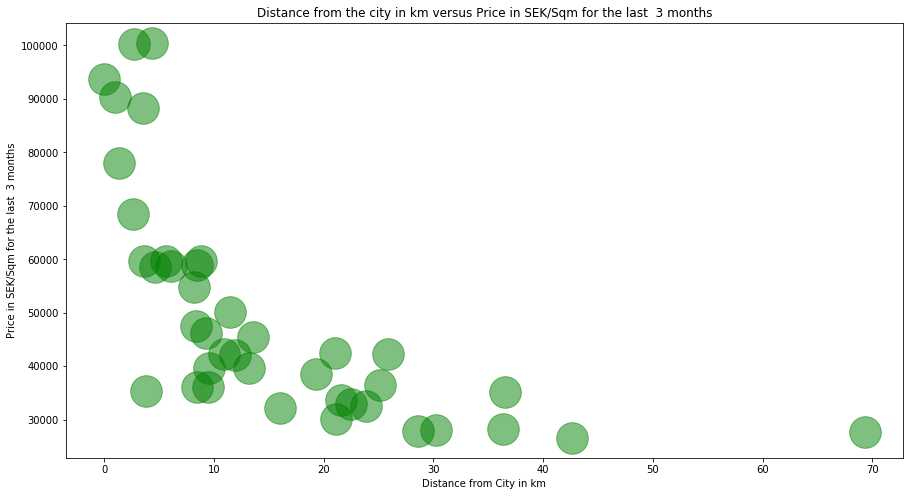

In [110]:
ax0 = Final.plot(kind='scatter',
                    x='Distance from City in km',
                    y='SEK/sqm 3 months',
                    figsize=(15, 8),
                    alpha=0.5,                  # transparency
                    color='green', # pass in weights 
                     s = 1000
                   )

ax0.set_ylabel('Price in SEK/Sqm for the last  3 months')
ax0.set_title('Distance from the city in km versus Price in SEK/Sqm for the last  3 months')

From the data presented in the figure above, it is quite clear that the prices are increasing the closest one is to the city.

Text(0.5, 1.0, 'Distance from the city in km versus Average dimension in Sqm of a house for the last  3 months')

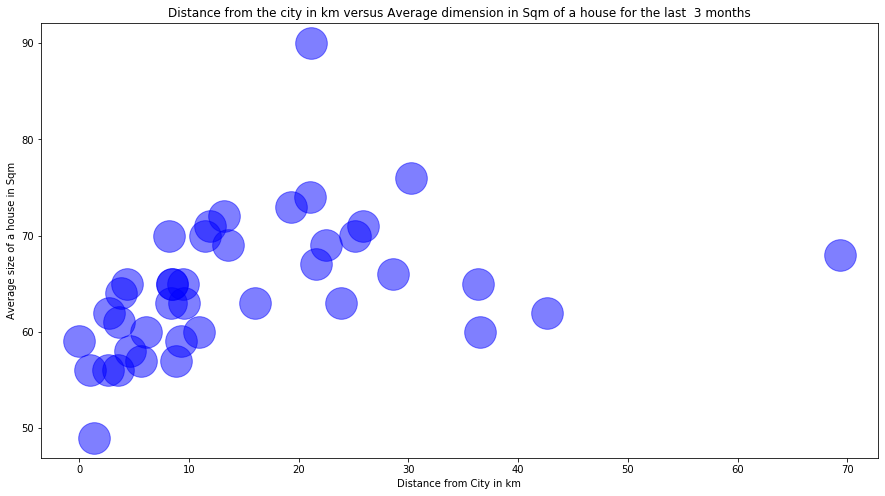

In [111]:
ax0 = Final.plot(kind='scatter',
                    x='Distance from City in km',
                    y='Av. size sqm',
                    figsize=(15, 8),
                    alpha=0.5,                  # transparency
                    color='blue', # pass in weights 
                     s = 1000
                   )

ax0.set_ylabel('Average size of a house in Sqm')
ax0.set_title('Distance from the city in km versus Average dimension in Sqm of a house for the last  3 months')

In [114]:

print ("The average size of a house in the Stockholm area is", Final["Av. size sqm"].mean(),"m.")

The average size of a house in the Stockholm area is 64.725 m.


From the data presented in the figure above, it is quite clear that the apartaments are smaller the closest one is to the city and then stabilizes to around 70 Sqm.

### 3.2 Growth of the prices for the different locations.
In this section, the change in price of the in the 3-months period and the 12-months period is evaluated. The clearer way to show it is using a bar plot from the _matplotlib_ library. The data are presented in discending order of distance from the city.

In [ ]:
import matplotlib.pyplot as plt

df_Growth_gr=pd.DataFrame([Final['Area'],Final["SEK/sqm 3 months"],Final["SEK/sqm 12 months"],Final["Distance from City in km"]]).transpose()
df_Growth_gr.head()

In [ ]:
df_Growth_gr.sort_values(['Distance from City in km'],ascending=False,axis=0,inplace=True)
df_Growth_gr.head()

In [117]:
df_Growth_gr.set_index('Area',inplace=True)
df_Growth_gr.head()

,SEK/sqm 3 months,SEK/sqm 12 months,Distance from City in km
Area,,,
Norrtalje,27643,26806,69.2781
Nynashamn,26565,25863,42.6213
Nykvarn,35162,32318,36.5466
Sigtuna,28207,29007,36.3354
Bro,27993,28177,30.2189


In [118]:
df_Growth_gr.drop(['Distance from City in km'],axis=1,inplace=True)

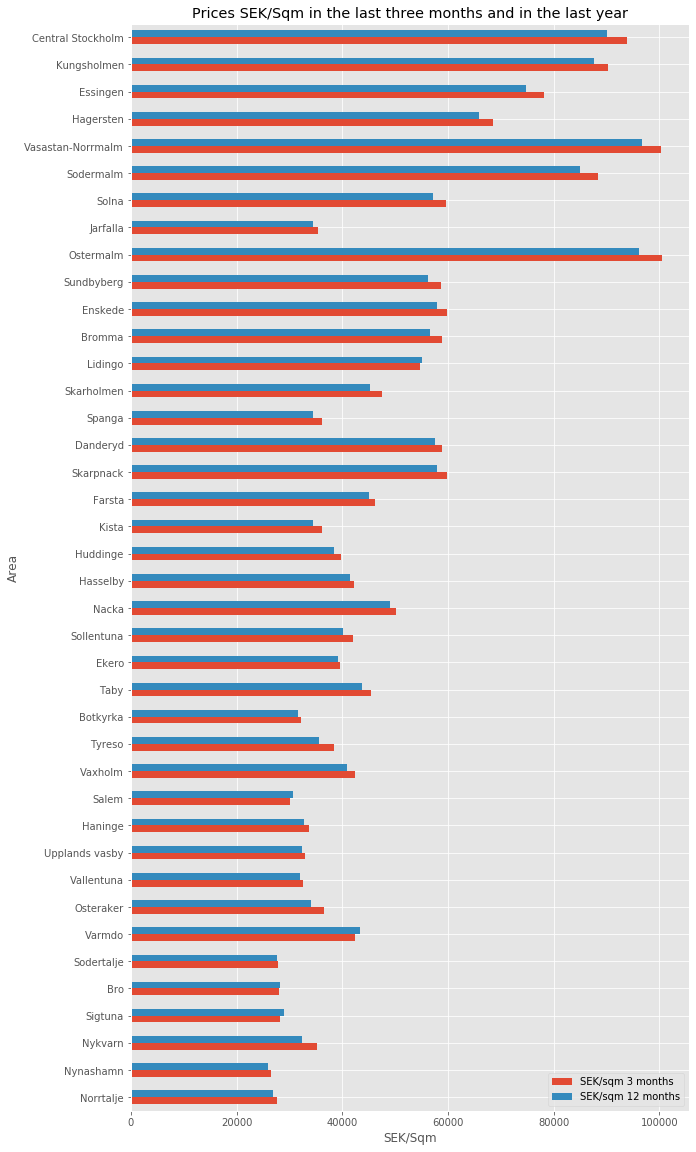

In [119]:
import matplotlib as mpl
mpl.style.use('ggplot') # optional: for ggplot-like style
df_Growth_gr.plot(kind='barh', figsize=(10, 20))

plt.xlabel("SEK/Sqm") # add to x-label to the plot
#plt.ylabel('Number of immigrants') # add y-label to the plot
plt.title('Prices SEK/Sqm in the last three months and in the last year') # add title to the plot

plt.show()

From the previous picture, it is possible to notice that the prices increased all over the Stockholm Län. The areas are ordered by vicinity to the city center. In general, the further one goes from the city, the least is the growth of the prices.

Also, it is possible to group the different areas to see the distribution of prices to see what one needs to spend.

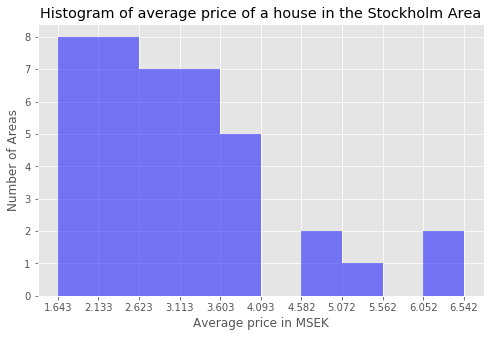

In [121]:
# np.histogram returns 2 values
new=(Final['Av. price SEK']/1e6)
count, bin_edges = np.histogram(new)

new.plot(kind='hist', figsize=(8, 5), xticks=bin_edges, color="blue",alpha=0.5)

plt.title('Histogram of average price of a house in the Stockholm Area') # add a title to the histogram
plt.ylabel('Number of Areas') # add y-label
plt.xlabel('Average price in MSEK') # add x-label

plt.show()

From the graph above, it is very clear that below 1.6 MSEK it is not possible to find anything. However, if someons's budget is around 4MSEK then one can look in many different areas.

### 3.3 Vulnerble areas, where one can find them?
A parameter to consider is also the safety of an area. In this section, the idea is to see where these areas are. To make this cearer, a weighted value is calculated and a color associated. The weigthing system works as the number of areas multiplied by 1,3,5 for V,R,E respectively.

In [122]:
vuln_df=pd.DataFrame([Final['Area'],Final['Latitude'], Final['Longitude'],Final['Distance from City in km'],Final["E"],Final["R"],Final["V"],Final['Av. price SEK']]).transpose()

In [123]:
vuln_df['weighted sum']=vuln_df['V']*1+vuln_df['R']*3+vuln_df['E']*5

In [ ]:
vuln_df["Col_vul"]=vuln_df['weighted sum'].apply(lambda x: 'orange' if x<=11 else "red")

vuln_df.loc[vuln_df['weighted sum']<=3,["Col_vul"]] = "yellow"
vuln_df.loc[vuln_df['weighted sum']<1,["Col_vul"]] = "green"

print('There are {} uniques categories.'.format(len(vuln_df['weighted sum'].unique())))

In [125]:
vuln_df.set_index(["Area"],inplace=True)

In [126]:
vuln_df.reset_index(inplace=True,drop=True)

In [127]:
vuln_df["Area"]=Final['Area']

In [ ]:
vuln_df.head()

In [128]:
color=vuln_df["Col_vul"]
index = [i  for i in range(40)]

In [130]:
# create map of STHLM
address = 'Stockholm, SE'
#Coordinates of Stockholm for Google 59.3293° N, 18.0686° E

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude


map_STHLM = folium.Map(location=[latitude, longitude], zoom_start=8)

# add markers to the map

for lat, lon, area, i in zip(vuln_df['Latitude'], vuln_df['Longitude'], vuln_df['Area'], index):
    label = '{}'.format(area)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=color[i],
        fill=True,
        fill_color=color[i],
        fill_opacity=0.5,
        parse_html=False).add_to(map_STHLM)
       

map_STHLM

One can also compare the prices to see if the fact that an area is at risk can influence them, i.e. for the same price is it possible to live in a safer area?

In [ ]:
vuln_df=vuln_df.sort_values(['Av. price SEK'],ascending=False,axis=0,inplace=True)
gr_test_g=vuln_df.loc[vuln_df['Col_vul'] == "green"]
gr_test_y=vuln_df.loc[vuln_df['Col_vul'] == "yellow"]
gr_test_o=vuln_df.loc[vuln_df['Col_vul'] == "orange"]
gr_test_r=vuln_df.loc[vuln_df['Col_vul'] == "red"]

In [ ]:
test=pd.DataFrame([vuln_df['Distance from City in km'],vuln_df['Av. price SEK']]).transpose()
test= test.applymap(str)

In [133]:
test["Distance from City in km"]=pd.to_numeric(test["Distance from City in km"])
test["Av. price SEK"]=pd.to_numeric(test["Av. price SEK"])

In [136]:
test.dtypes

Distance from City in km    float64
Av. price SEK               float64
dtype: object

Text(0.5, 1.0, 'Distance from the city in km versus average price of houses sold in the area')

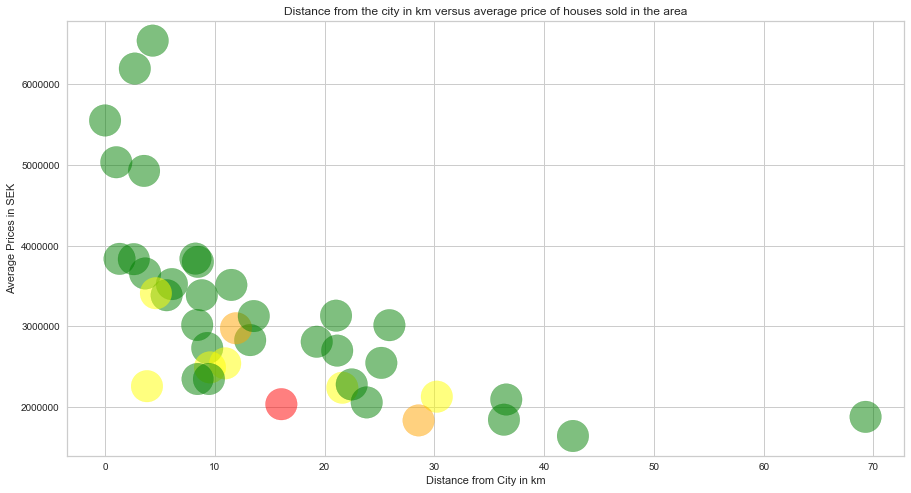

In [326]:
ax0 = test.plot(kind='scatter',
                    x='Distance from City in km',
                    y='Av. price SEK',
                    figsize=(15, 8),
                    alpha=0.5,                  # transparency
                    color=color, # pass in weights 
                    s = 1000
                
                   )
ax0.set_ylabel('Average Prices in SEK')
ax0.set_title('Distance from the city in km versus average price of houses sold in the area')

From the graph it is quite clear that the areas with higher vulnerability have lower prices. However, for similar prices it is possible to find houses in similarly distanced areas that are not labelled as vulnerable.

### 3.4 K-mean to see affinities among areas excluding the prices. Can one live in a cheaper area with the same amenities and transportations?

In this section, for each area the 10 most common amenities will be found. Then this dataframe will be merged with the one including public transportations and vulerabile areas.
Finally, on this data set a K-cluster will be runned to see any pattern.

In [153]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In the following table, the 10 most common venues for each area are shown.

In [155]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Area']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
area_venues_sorted = pd.DataFrame(columns=columns)
area_venues_sorted['Area'] = Sthlm_grouped['Area']

for ind in np.arange(Sthlm_grouped.shape[0]):
    area_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Sthlm_grouped.iloc[ind, :], num_top_venues)
area_venues_sorted.set_index(['Area'],inplace=True)
area_venues_sorted.head(40)

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Area,,,,,,,,,,
Botkyrka,Fast Food Restaurant,Scandinavian Restaurant,Café,Park,Yoga Studio,Event Space,Food Truck,Food Court,Food & Drink Shop,Flea Market
Bro,Grocery Store,Pizza Place,Gym Pool,Yoga Studio,Food Truck,Food Court,Food & Drink Shop,Flea Market,Fish Market,Fast Food Restaurant
Bromma,Pizza Place,Food & Drink Shop,Playground,Convenience Store,Plaza,Bistro,Lake,Metro Station,Thai Restaurant,Soccer Field
Central Stockholm,Beach,Scandinavian Restaurant,Café,Park,Restaurant,Grocery Store,Harbor / Marina,Pizza Place,Thai Restaurant,Chinese Restaurant
Danderyd,Gym / Fitness Center,Italian Restaurant,Liquor Store,Pool,IT Services,Restaurant,Salon / Barbershop,Bus Stop,Supermarket,Sushi Restaurant
Ekero,Stables,Golf Course,Café,Yoga Studio,Frame Store,Football Stadium,Food Truck,Food Court,Food & Drink Shop,Flea Market
Enskede,Supermarket,Bakery,Metro Station,Thai Restaurant,Park,Stadium,Stables,Furniture / Home Store,Restaurant,Pizza Place
Essingen,Bus Stop,Soccer Field,Bakery,Park,Café,Light Rail Station,Deli / Bodega,Italian Restaurant,Bay,Scandinavian Restaurant
Farsta,Pizza Place,Grocery Store,Italian Restaurant,Coffee Shop,Department Store,Café,Sushi Restaurant,Shopping Plaza,Fast Food Restaurant,Smoke Shop


In [156]:
vuln_k=pd.DataFrame([Final['Area'],Final["E"],Final["R"],Final["V"]]).transpose()
vuln_k.set_index(vuln_k['Area'],inplace=True,drop=True)

In [ ]:
vuln_k.drop(['Area'],axis=1,inplace=True)

In [ ]:
public_transportation.head()

In [159]:
Sthlm_grouped.set_index(['Area'],inplace=True,drop=True)
k_cluster1=public_transportation.join(vuln_k, how='outer')
k_cluster_sthlm=k_cluster1.join(Sthlm_grouped,how="outer")

In [160]:
k_cluster_sthlm=k_cluster_sthlm.fillna(0)
k_cluster_sthlm.head()

,Metro stations,Bus stops,Tram stops,Train stations,E,R,V,Accessories Store,Airport Terminal,American Restaurant,Amphitheater,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Court,Bathing Area,Bay,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Burger Joint,Bus Stop,Business Service,Café,Candy Store,Castle,Caucasian Restaurant,Chinese Restaurant,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Czech Restaurant,Deli / Bodega,Department Store,Design Studio,Diner,Discount Store,Dive Bar,Doctor's Office,Eastern European Restaurant,Electronics Store,Event Space,Falafel Restaurant,Fast Food Restaurant,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Forest,Frame Store,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden Center,Gastropub,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,Historic Site,History Museum,Hot Dog Joint,IT Services,Ice Cream Shop,Indian Restaurant,Indoor Play Area,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Lake,Light Rail Station,Liquor Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Mongolian Restaurant,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Neighborhood,Newsstand,Nightclub,Noodle House,Office,Organic Grocery,Other Great Outdoors,Park,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Pool,Pub,Racetrack,Rafting,Ramen Restaurant,Record Shop,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Area,Smoke Shop,Soccer Field,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Stables,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Stadium,Thai Restaurant,Theater,Theme Park,Thrift / Vintage Store,Toy / Game Store,Trail,Vacation Rental,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
Area,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Botkyrka,0.0,1.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.250000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.25,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.250000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.25000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
Bro,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0

Above the snippet of the data used is shown. It includes amenities, transportation and vulnerability.
One can analyze the number of clusters that better fit the data by using the elbow graph, where the distribution score is calculated for each k.

In [ ]:
!conda install -c districtdatalabs yellowbrick -y

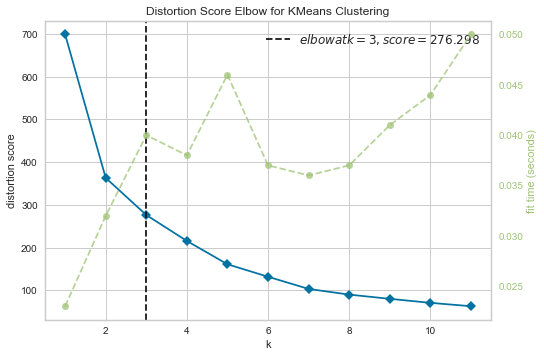

In [164]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer

# Generate synthetic dataset with 8 random clusters
X=k_cluster_sthlm

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show() 

At his point, we apply the k-mean algorithm to see similarities in within the areas.
The table here includes all the data we had until now, after merging the dataframes used for k-mean and the one including the prices. From the graph above, k=3 will be applied.

In [208]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(k_cluster_sthlm)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

,Cluster Labels,Metro stations,Bus stops,Tram stops,Train stations,E,R,V,Accessories Store,Airport Terminal,American Restaurant,Amphitheater,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Court,Bathing Area,Bay,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Burger Joint,Bus Stop,Business Service,Café,Candy Store,Castle,Caucasian Restaurant,Chinese Restaurant,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Czech Restaurant,Deli / Bodega,Department Store,Design Studio,Diner,Discount Store,Dive Bar,Doctor's Office,Eastern European Restaurant,Electronics Store,Event Space,Falafel Restaurant,Fast Food Restaurant,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Forest,Frame Store,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden Center,Gastropub,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,Historic Site,History Museum,Hot Dog Joint,IT Services,Ice Cream Shop,Indian Restaurant,Indoor Play Area,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Lake,Light Rail Station,Liquor Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Mongolian Restaurant,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Neighborhood,Newsstand,Nightclub,Noodle House,Office,Organic Grocery,Other Great Outdoors,Park,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Pool,Pub,Racetrack,Rafting,Ramen Restaurant,Record Shop,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Area,Smoke Shop,Soccer Field,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Stables,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Stadium,Thai Restaurant,Theater,Theme Park,Thrift / Vintage Store,Toy / Game Store,Trail,Vacation Rental,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
Area,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Botkyrka,1,0.0,1.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.250000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.25,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.250000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.25000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
Bro,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0

In [ ]:
# add clustering labels
k_cluster_sthlm.insert(0, 'Cluster Labels', kmeans.labels_)

In [ ]:
Final.set_index(['Area'],inplace=True)
Final.drop(["E","R","V"],axis=1, inplace=True)

In [168]:
part_merged= Final.join(k_cluster_sthlm["Cluster Labels"],how='outer')

In [169]:
all_data_merged=part_merged.join(area_venues_sorted,how='outer')

In [170]:
all_data_merged.head()

,SEK/sqm 3 months,Av. price SEK,SEK/sqm 12 months,Growth %,Av. size sqm,Latitude,Longitude,Distance from City in km,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Area,,,,,,,,,,,,,,,,,,,
Botkyrka,32151.0,2037000.0,31645.0,1.598989,63.0,59.2168,17.8268,16.056763,1,Fast Food Restaurant,Scandinavian Restaurant,Café,Park,Yoga Studio,Event Space,Food Truck,Food Court,Food & Drink Shop,Flea Market
Bro,27993.0,2130000.0,28177.0,-0.653015,76.0,59.5167,17.6333,30.218892,1,Grocery Store,Pizza Place,Gym Pool,Yoga Studio,Food Truck,Food Court,Food & Drink Shop,Flea Market,Fish Market,Fast Food Restaurant
Bromma,58832.0,3525000.0,56586.0,3.969180,60.0,59.3500,17.9167,6.089372,1,Pizza Place,Food & Drink Shop,Playground,Convenience Store,Plaza,Bistro,Lake,Metro Station,Thai Restaurant,Soccer Field
Central Stockholm,93787.0,5553000.0,90158.0,4.025156,59.0,59.3255,18.0127,0.000000,0,Beach,Scandinavian Restaurant,Café,Park,Restaurant,Grocery Store,Harbor / Marina,Pizza Place,Thai Restaurant,Chinese Restaurant
Danderyd,58848.0,3801000.0,57588.0,2.187956,65.0,59.3998,18.0442,8.455056,0,Gym / Fitness Center,Italian Restaurant,Liquor Store,Pool,IT Services,Restaurant,Salon / Barbershop,Bus Stop,Supermarket,Sushi Restaurant


Finally, all the data are merged, including the price ones so can give a better overview about each cluster.

In [172]:
all_data_merged.reset_index(inplace=True)

In [177]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=8)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
#all_data_merged.reset_index(inplace=True)
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(all_data_merged['Latitude'], all_data_merged['Longitude'], all_data_merged['Area'], all_data_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters

For each cluster, one can print the value of:
- growth, size, distance, kSEK/sqm, 10 most common venues;
- description of the numerical value, involving the 4 cateogory mention above;
- the most common word among the 10 category.

In [204]:
Cluster1=all_data_merged.loc[all_data_merged['Cluster Labels'] == 0]
Cluster1= Cluster1.round({'Growth': 2, 'Ditance from City in km': 1})
Cluster1["kSEK/sqm 3 months"]= Cluster1["SEK/sqm 3 months"]/1e3
Cluster1.drop(["Latitude","Longitude","Cluster Labels","SEK/sqm 12 months","Av. price SEK","SEK/sqm 3 months"],axis=1,inplace=True)
print("Cluster 0  and is made of  ", len(Cluster1.index),'elements:' )
Cluster1.set_index("Area",inplace=True)
rounded_Cluster1 = Cluster1.round(decimals=1)
rounded_Cluster1.head(10)

Cluster 0  and is made of   10 elements:


,Growth %,Av. size sqm,Distance from City in km,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,kSEK/sqm 3 months
Area,,,,,,,,,,,,,,
Central Stockholm,4.0,59.0,0.0,Beach,Scandinavian Restaurant,Café,Park,Restaurant,Grocery Store,Harbor / Marina,Pizza Place,Thai Restaurant,Chinese Restaurant,93.8
Danderyd,2.2,65.0,8.5,Gym / Fitness Center,Italian Restaurant,Liquor Store,Pool,IT Services,Restaurant,Salon / Barbershop,Bus Stop,Supermarket,Sushi Restaurant,58.8
Hasselby,1.9,60.0,10.9,Convenience Store,Gym,Event Space,Metro Station,Supermarket,Scandinavian Restaurant,Thai Restaurant,Grocery Store,Smoke Shop,Pizza Place,42.3
Kungsholmen,3.0,56.0,1.0,Gym / Fitness Center,Scandinavian Restaurant,Café,Bakery,Indian Restaurant,Park,Playground,Salad Place,Restaurant,Coffee Shop,90.3
Ostermalm,4.6,65.0,4.3,Scandinavian Restaurant,Park,Bakery,Seafood Restaurant,Gym / Fitness Center,Coffee Shop,Bar,History Museum,Burger Joint,Lounge,100.5
Skarpnack,3.2,57.0,8.8,Café,Park,Pizza Place,Bus Stop,Supermarket,Metro Station,Church,Grocery Store,Other Great Outdoors,Falafel Restaurant,59.7
Sollentuna,5.1,71.0,11.9,Pizza Place,Coffee Shop,Gym / Fitness Center,Sushi Restaurant,Grocery Store,Italian Restaurant,Café,Steakhouse,Furniture / Home Store,Shopping Mall,42.1
Solna,4.2,61.0,3.6,Bus Stop,Indian Restaurant,Grocery Store,Café,Greek Restaurant,Fast Food Restaurant,Burger Joint,Supermarket,Thai Restaurant,Climbing Gym,59.7
Sundbyberg,4.1,58.0,4.6,Scandinavian Restaurant,Gym / Fitness Center,Pizza Place,Café,Grocery Store,Burger Joint,Sushi Restaurant,Asian Restaurant,Restaurant,Park,58.6


In [205]:
Cluster1.describe()

,Growth %,Av. size sqm,Distance from City in km,kSEK/sqm 3 months
count,10.000000,10.00000,10.000000,10.000000
mean,3.592248,62.10000,6.732282,65.118800
std,1.021114,5.15213,4.667299,21.832318
min,1.889202,56.00000,0.000000,42.107000
25%,3.047366,58.25000,3.821634,48.690000
50%,3.834745,60.50000,6.541782,59.252500
75%,4.187235,65.00000,10.411831,82.643250
max,5.086226,71.00000,13.546269,100.523000


From each cluster, it is also possible to extract the most frequent activity, unifiing the entris as coffee bar and cafés or restaurants. For each cluster, here are the 10 most common words among the 10 most diffused activities.

In [207]:
from collections import Counter 
ClusterT=Cluster1.T
ClusterT.drop(index=["Growth %","Av. size sqm", "kSEK/sqm 3 months"],inplace=True)
#my_cols = set(Cluster1T.columns)
Counting = Counter(ClusterT[set(ClusterT.columns)].to_string().split())
#most_occur = Counting.most_common(10) 
most_common_words=pd.DataFrame(Counting.most_common()  , columns=['words','How often'])
indexNames = most_common_words[most_common_words['How often'] <= 1 ].index
symbols1 = most_common_words[most_common_words['words'] == '/' ].index
symbols2 = most_common_words[most_common_words['words'] == '&' ].index
mo = most_common_words[most_common_words['words'] == 'Most' ].index
co = most_common_words[most_common_words['words'] == 'Common' ].index
ve = most_common_words[most_common_words['words'] == 'Venue' ].index
# Delete these row indexes from dataFrame
#most_common_words.drop(indexNames , inplace=True)
most_common_words.drop(symbols1 , inplace=True)
most_common_words.drop(symbols2 , inplace=True)
most_common_words.drop(co , inplace=True)
most_common_words.drop(mo , inplace=True)
most_common_words.drop( most_common_words[most_common_words['words'] == 'Center' ].index, inplace=True)
most_common_words.drop( most_common_words[most_common_words['words'] == 'Place' ].index, inplace=True)
most_common_words.drop(ve , inplace=True)
most_common_words.head(10)

,words,How often
0,Restaurant,26
1,Store,14
6,Gym,7
8,Grocery,7
9,Café,6
10,Pizza,6
11,Fitness,5
13,Scandinavian,5
14,Park,5
15,Shop,5


In [237]:
Cluster1_just_numbers=k_cluster_sthlm.loc[k_cluster_sthlm['Cluster Labels'] == 0]

Cluster1_just_numbers.head(10)

,Cluster Labels,Metro stations,Bus stops,Tram stops,Train stations,E,R,V,Accessories Store,Airport Terminal,American Restaurant,Amphitheater,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Court,Bathing Area,Bay,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Burger Joint,Bus Stop,Business Service,Café,Candy Store,Castle,Caucasian Restaurant,Chinese Restaurant,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Czech Restaurant,Deli / Bodega,Department Store,Design Studio,Diner,Discount Store,Dive Bar,Doctor's Office,Eastern European Restaurant,Electronics Store,Event Space,Falafel Restaurant,Fast Food Restaurant,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Forest,Frame Store,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden Center,Gastropub,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,Historic Site,History Museum,Hot Dog Joint,IT Services,Ice Cream Shop,Indian Restaurant,Indoor Play Area,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Lake,Light Rail Station,Liquor Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Mongolian Restaurant,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Neighborhood,Newsstand,Nightclub,Noodle House,Office,Organic Grocery,Other Great Outdoors,Park,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Pool,Pub,Racetrack,Rafting,Ramen Restaurant,Record Shop,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Area,Smoke Shop,Soccer Field,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Stables,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Stadium,Thai Restaurant,Theater,Theme Park,Thrift / Vintage Store,Toy / Game Store,Trail,Vacation Rental,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
Area,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Central Stockholm,0,2.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.018868,0.0,0.0000,0.018868,0.000000,0.000000,0.0,0.0,0.094340,0.0,0.000000,0.0,0.0000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.018868,0.0,0.075472,0.0,0.000000,0.000000,0.018868,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.018868,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.018868,0.0,0.000000,0.00000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.056604,0.000000,0.018868,0.0,0.037736,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.018868,0.0,0.000000,0.018868,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.018868,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.018868,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.018868,0.0,0.0,0.056604,0.000000,0.0,0.0,0.0000,0.0,0.018868,0.0,0.037736,0.018868,0.000000,0.000000,0.000000,0.00000,0.018868,0.000000,0.0,0.056604,0.018868,0.000000,0.000000,0.094340,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.018868,0.0,0.0,0.0,0.000000,0.018868,0.0,0.000000,0.000000,0.018868,0.0,0.000000

In [239]:
new=k_cluster_sthlm
new.reset_index(inplace=True)
new_gr=new.groupby(["Cluster Labels"]).sum()
new_gr.head()

,Metro stations,Bus stops,Tram stops,Train stations,E,R,V,Accessories Store,Airport Terminal,American Restaurant,Amphitheater,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Court,Bathing Area,Bay,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Burger Joint,Bus Stop,Business Service,Café,Candy Store,Castle,Caucasian Restaurant,Chinese Restaurant,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Czech Restaurant,Deli / Bodega,Department Store,Design Studio,Diner,Discount Store,Dive Bar,Doctor's Office,Eastern European Restaurant,Electronics Store,Event Space,Falafel Restaurant,Fast Food Restaurant,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Forest,Frame Store,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden Center,Gastropub,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,Historic Site,History Museum,Hot Dog Joint,IT Services,Ice Cream Shop,Indian Restaurant,Indoor Play Area,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Lake,Light Rail Station,Liquor Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Mongolian Restaurant,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Neighborhood,Newsstand,Nightclub,Noodle House,Office,Organic Grocery,Other Great Outdoors,Park,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Pool,Pub,Racetrack,Rafting,Ramen Restaurant,Record Shop,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Area,Smoke Shop,Soccer Field,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Stables,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Stadium,Thai Restaurant,Theater,Theme Park,Thrift / Vintage Store,Toy / Game Store,Trail,Vacation Rental,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
Cluster Labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,20.0,41.0,10.0,43.0,0.0,2.0,2.0,0.00,0.000000,0.067287,0.000000,0.000000,0.010638,0.020833,0.113770,0.018868,0.00,0.012500,0.140989,0.031915,0.010204,0.000000,0.000000,0.104544,0.000,0.020842,0.00,0.012500,0.000000,0.010638,0.00,0.010204,0.00,0.010204,0.000000,0.145242,0.283239,0.0,0.473989,0.00,0.010204,0.010204,0.041572,0.1,0.020833,0.083809,0.010638,0.209157,0.010638,0.000000,0.242462,0.010638,0.00,0.00,0.052645,0.101872,0.010638,0.000000,0.000000,0.00,0.000000,0.000000,0.091243,0.118868,0.00,0.078557,0.02439,0.024390,0.000000,0.000000,0.00000,0.032258,0.00,0.02439,0.021277,0.000000,0.128567,0.000000,0.020833,0.000000,0.000000,0.010638,0.041667,0.541828,0.122704,0.386543,0.00,0.050236,0.000000,0.045224,0.000000,0.021277,0.010638,0.079167,0.010204,0.126351,0.000000,0.167296,0.062414,0.024390,0.032258,0.000000,0.020833,0.000000,0.020833,0.195924,0.021277,0.020833,0.02439,0.00,0.000000,0.222704,0.045224,0.032908,0.018868,0.04211,0.010204,0.010204,0.00,0.044758,0.02439,0.000000,0.00,0.020842,0.000000,0.029072,0.00,0.100000,0.298307,0.020833,0.00,0.00,0.012500,0.00,0.018868,0.00,0.498105,0.060118,0.063730,0.100009,0.07688,0.02439,0.029072,0.020408,0.00,0.255112,0.060118,0.066667,0

Finally one can see the summary of all the data for the cluster, for each cluster the data are grouped together and one can easily see in total the distribution of publict ransportations, vulnerable areas and all the venues.
This can also be shown in a histogram.

In [259]:
new_gr["Transport"]=(new_gr["Metro stations"]+new_gr["Bus stops"]+new_gr["Tram stops"] + new_gr["Train stations"])

In [260]:
new_gr.head()

,Metro stations,Bus stops,Tram stops,Train stations,E,R,V,Accessories Store,Airport Terminal,American Restaurant,Amphitheater,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Court,Bathing Area,Bay,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Burger Joint,Bus Stop,Business Service,Café,Candy Store,Castle,Caucasian Restaurant,Chinese Restaurant,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Czech Restaurant,Deli / Bodega,Department Store,Design Studio,Diner,Discount Store,Dive Bar,Doctor's Office,Eastern European Restaurant,Electronics Store,Event Space,Falafel Restaurant,Fast Food Restaurant,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Forest,Frame Store,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden Center,Gastropub,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,Historic Site,History Museum,Hot Dog Joint,IT Services,Ice Cream Shop,Indian Restaurant,Indoor Play Area,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Lake,Light Rail Station,Liquor Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Mongolian Restaurant,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Neighborhood,Newsstand,Nightclub,Noodle House,Office,Organic Grocery,Other Great Outdoors,Park,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Pool,Pub,Racetrack,Rafting,Ramen Restaurant,Record Shop,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Area,Smoke Shop,Soccer Field,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Stables,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Stadium,Thai Restaurant,Theater,Theme Park,Thrift / Vintage Store,Toy / Game Store,Trail,Vacation Rental,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio,Transport
Cluster Labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,20.0,41.0,10.0,43.0,0.0,2.0,2.0,0.00,0.000000,0.067287,0.000000,0.000000,0.010638,0.020833,0.113770,0.018868,0.00,0.012500,0.140989,0.031915,0.010204,0.000000,0.000000,0.104544,0.000,0.020842,0.00,0.012500,0.000000,0.010638,0.00,0.010204,0.00,0.010204,0.000000,0.145242,0.283239,0.0,0.473989,0.00,0.010204,0.010204,0.041572,0.1,0.020833,0.083809,0.010638,0.209157,0.010638,0.000000,0.242462,0.010638,0.00,0.00,0.052645,0.101872,0.010638,0.000000,0.000000,0.00,0.000000,0.000000,0.091243,0.118868,0.00,0.078557,0.02439,0.024390,0.000000,0.000000,0.00000,0.032258,0.00,0.02439,0.021277,0.000000,0.128567,0.000000,0.020833,0.000000,0.000000,0.010638,0.041667,0.541828,0.122704,0.386543,0.00,0.050236,0.000000,0.045224,0.000000,0.021277,0.010638,0.079167,0.010204,0.126351,0.000000,0.167296,0.062414,0.024390,0.032258,0.000000,0.020833,0.000000,0.020833,0.195924,0.021277,0.020833,0.02439,0.00,0.000000,0.222704,0.045224,0.032908,0.018868,0.04211,0.010204,0.010204,0.00,0.044758,0.02439,0.000000,0.00,0.020842,0.000000,0.029072,0.00,0.100000,0.298307,0.020833,0.00,0.00,0.012500,0.00,0.018868,0.00,0.498105,0.060118,0.063730,0.100009,0.07688,0.02439,0.029072,0.020408,0.00,0.255112,0.060118

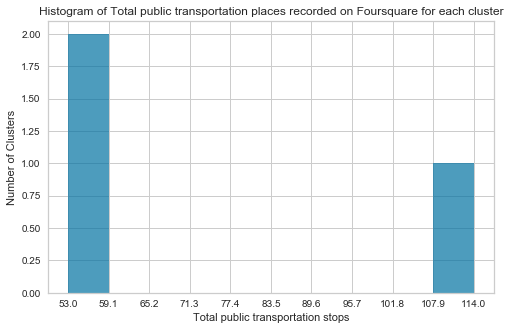

In [266]:
count, bin_edges = np.histogram(new_gr["Transport"])

new_gr["Transport"].plot(kind='hist', figsize=(8, 5), xticks=bin_edges, alpha=0.7)

plt.title('Histogram of Total public transportation places recorded on Foursquare for each cluster') # add a title to the histogram
plt.ylabel('Number of Clusters') # add y-label
plt.xlabel('Total public transportation stops') # add x-label

plt.show()

In [276]:
new_gr[["E","R","V"]].head()

,E,R,V
Cluster Labels,,,
0,0.0,2.0,2.0
1,4.0,2.0,8.0
2,0.0,0.0,0.0


For what concern the vulnerabilty, most of the areas are included in the cluster 1.

In [280]:
new_gr.drop(["E","R","V","Metro stations","Bus stops","Tram stops","Train stations","Transport"], axis=1,inplace=True)

In [282]:
new_gr.T[(new_gr != 0).any()].T # or df.loc[:, (df != 0).any()]

,Accessories Store,Airport Terminal,American Restaurant,Amphitheater,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Court,Bathing Area,Bay,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Burger Joint,Bus Stop,Business Service,Café,Candy Store,Castle,Caucasian Restaurant,Chinese Restaurant,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Czech Restaurant,Deli / Bodega,Department Store,Design Studio,Diner,Discount Store,Dive Bar,Doctor's Office,Eastern European Restaurant,Electronics Store,Event Space,Falafel Restaurant,Fast Food Restaurant,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Forest,Frame Store,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden Center,Gastropub,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,Historic Site,History Museum,Hot Dog Joint,IT Services,Ice Cream Shop,Indian Restaurant,Indoor Play Area,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Lake,Light Rail Station,Liquor Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Mongolian Restaurant,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Neighborhood,Newsstand,Nightclub,Noodle House,Office,Organic Grocery,Other Great Outdoors,Park,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Pool,Pub,Racetrack,Rafting,Ramen Restaurant,Record Shop,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Area,Smoke Shop,Soccer Field,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Stables,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Stadium,Thai Restaurant,Theater,Theme Park,Thrift / Vintage Store,Toy / Game Store,Trail,Vacation Rental,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
Cluster Labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.00,0.000000,0.067287,0.000000,0.000000,0.010638,0.020833,0.113770,0.018868,0.00,0.012500,0.140989,0.031915,0.010204,0.000000,0.000000,0.104544,0.000,0.020842,0.00,0.012500,0.000000,0.010638,0.00,0.010204,0.00,0.010204,0.000000,0.145242,0.283239,0.0,0.473989,0.00,0.010204,0.010204,0.041572,0.1,0.020833,0.083809,0.010638,0.209157,0.010638,0.000000,0.242462,0.010638,0.00,0.00,0.052645,0.101872,0.010638,0.000000,0.000000,0.00,0.000000,0.000000,0.091243,0.118868,0.00,0.078557,0.02439,0.024390,0.000000,0.000000,0.00000,0.032258,0.00,0.02439,0.021277,0.000000,0.128567,0.000000,0.020833,0.000000,0.000000,0.010638,0.041667,0.541828,0.122704,0.386543,0.00,0.050236,0.000000,0.045224,0.000000,0.021277,0.010638,0.079167,0.010204,0.126351,0.000000,0.167296,0.062414,0.024390,0.032258,0.000000,0.020833,0.000000,0.020833,0.195924,0.021277,0.020833,0.02439,0.00,0.000000,0.222704,0.045224,0.032908,0.018868,0.04211,0.010204,0.010204,0.00,0.044758,0.02439,0.000000,0.00,0.020842,0.000000,0.029072,0.00,0.100000,0.298307,0.020833,0.00,0.00,0.012500,0.00,0.018868,0.00,0.498105,0.060118,0.063730,0.100009,0.07688,0.02439,0.029072,0.020408,0.00,0.255112,0.060118,0.066667,0.010204,0.501202,0.010204,0.031915,0.010638,0.020833,0.100620,0.000000,0.029072,0.000000,0.00000

In [294]:
test_B=new_gr.T[(new_gr >=0.1).any()].T # or df.loc[:, (df != 0).any()]

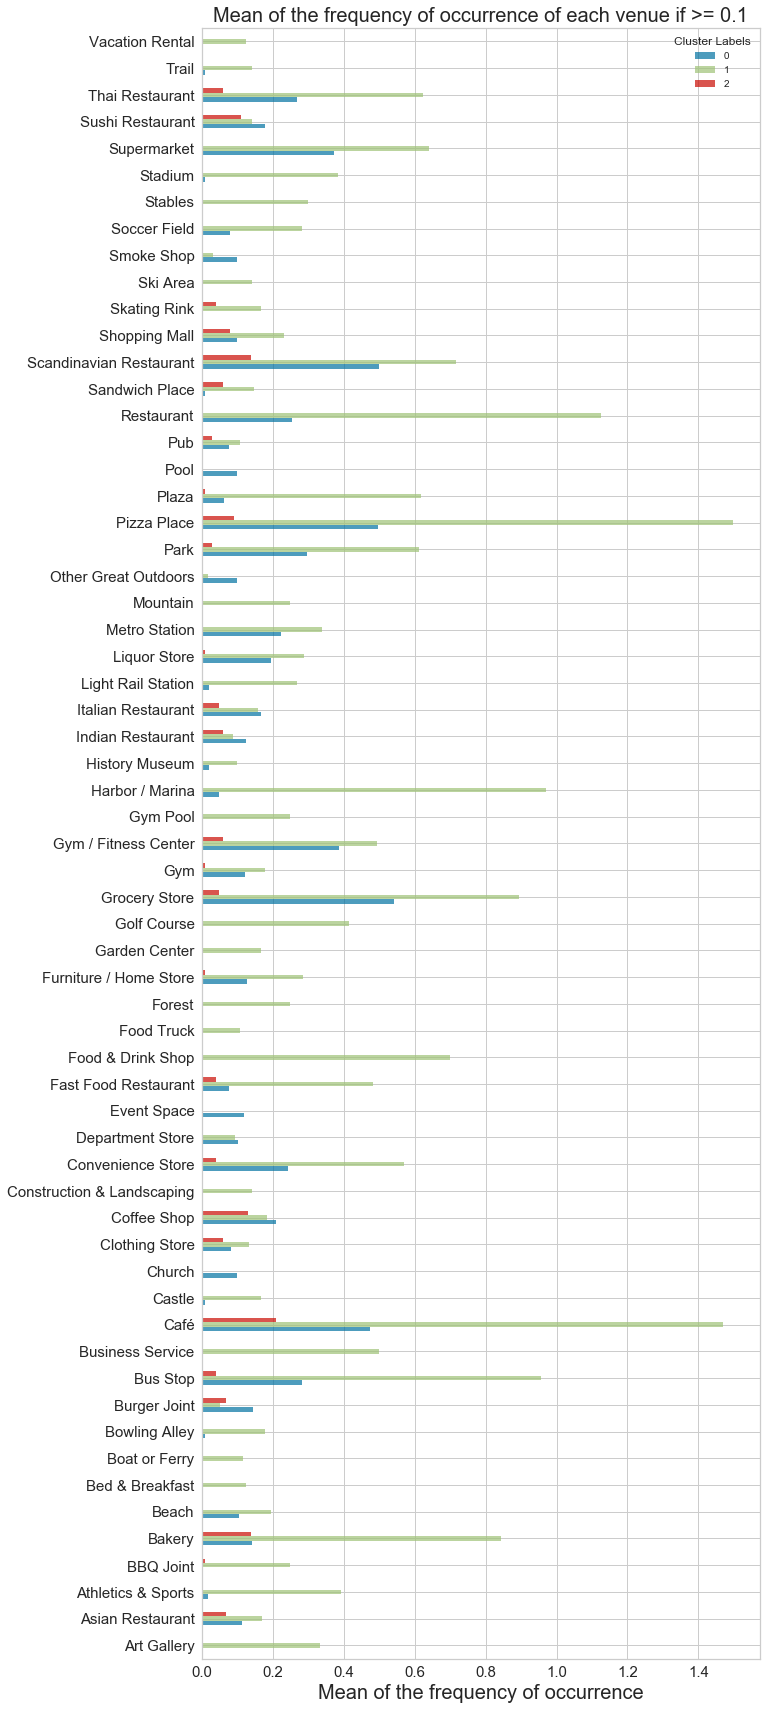

In [316]:
test_b=test_B.transpose()
test_b.plot(kind='barh', figsize=(10, 30) , alpha=0.7,fontsize=15)

plt.title('Mean of the frequency of occurrence of each venue if >= 0.1', fontsize=20) # add a title to the histogram
plt.ylabel('', fontsize=18) # add y-label
plt.xlabel('Mean of the frequency of occurrence', fontsize=20)# add x-label
plt.show()

Let's briefly repeat the process made for CLuster 0 to Cluster 1 and 2, and let's print the data. It is visible from the table below that Nynashamn	has no data on th Foursqaure database.

In [319]:
Cluster1=all_data_merged.loc[all_data_merged['Cluster Labels'] == 1]
Cluster1= Cluster1.round({'Growth': 2, 'Ditance from City in km': 1})
Cluster1["kSEK/sqm 3 months"]= Cluster1["SEK/sqm 3 months"]/1e3
Cluster1.drop(["Latitude","Longitude","Cluster Labels","SEK/sqm 12 months","Av. price SEK","SEK/sqm 3 months"],axis=1,inplace=True)
print("Cluster 1 and is made of  ", len(Cluster1.index),'elements:' )
Cluster1.set_index("Area",inplace=True)
rounded_Cluster1 = Cluster1.round(decimals=1)
rounded_Cluster1.head(30)

Cluster 1 and is made of   27 elements:


,Growth %,Av. size sqm,Distance from City in km,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,kSEK/sqm 3 months
Area,,,,,,,,,,,,,,
Botkyrka,1.6,63.0,16.1,Fast Food Restaurant,Scandinavian Restaurant,Café,Park,Yoga Studio,Event Space,Food Truck,Food Court,Food & Drink Shop,Flea Market,32.2
Bro,-0.7,76.0,30.2,Grocery Store,Pizza Place,Gym Pool,Yoga Studio,Food Truck,Food Court,Food & Drink Shop,Flea Market,Fish Market,Fast Food Restaurant,28.0
Bromma,4.0,60.0,6.1,Pizza Place,Food & Drink Shop,Playground,Convenience Store,Plaza,Bistro,Lake,Metro Station,Thai Restaurant,Soccer Field,58.8
Ekero,0.8,72.0,13.2,Stables,Golf Course,Café,Yoga Studio,Frame Store,Football Stadium,Food Truck,Food Court,Food & Drink Shop,Flea Market,39.6
Enskede,3.2,57.0,5.6,Supermarket,Bakery,Metro Station,Thai Restaurant,Park,Stadium,Stables,Furniture / Home Store,Restaurant,Pizza Place,59.7
Essingen,4.5,49.0,1.3,Bus Stop,Soccer Field,Bakery,Park,Café,Light Rail Station,Deli / Bodega,Italian Restaurant,Bay,Scandinavian Restaurant,78.1
Farsta,2.4,59.0,9.3,Pizza Place,Grocery Store,Italian Restaurant,Coffee Shop,Department Store,Café,Sushi Restaurant,Shopping Plaza,Fast Food Restaurant,Smoke Shop,46.2
Hagersten,4.1,56.0,2.6,Pizza Place,Café,Park,Thai Restaurant,Grocery Store,Bakery,Bus Stop,Metro Station,Convenience Store,Food Court,68.6
Haninge,2.9,67.0,21.6,Convenience Store,Restaurant,Golf Course,Electronics Store,Food Truck,Food Court,Food & Drink Shop,Flea Market,Fish Market,Fast Food Restaurant,33.7


In [320]:
Cluster1.describe()


,Growth %,Av. size sqm,Distance from City in km,kSEK/sqm 3 months
count,27.000000,27.000000,27.000000,27.000000
mean,2.803412,65.962963,19.078987,41.200519
std,2.880782,7.728476,15.072144,13.164496
min,-2.757955,49.000000,1.316866,26.565000
25%,1.205605,62.500000,8.408488,32.363500
50%,2.944324,65.000000,16.056763,36.460000
75%,4.308515,70.000000,25.532205,46.886000
max,8.800050,90.000000,69.278111,78.079000


In [321]:
from collections import Counter 
ClusterT=Cluster1.T
ClusterT.drop(index=["Growth %","Av. size sqm", "kSEK/sqm 3 months"],inplace=True)
#my_cols = set(Cluster1T.columns)
Counting = Counter(ClusterT[set(ClusterT.columns)].to_string().split())
#most_occur = Counting.most_common(10) 
most_common_words=pd.DataFrame(Counting.most_common()  , columns=['words','How often'])
indexNames = most_common_words[most_common_words['How often'] <= 1 ].index
symbols1 = most_common_words[most_common_words['words'] == '/' ].index
symbols2 = most_common_words[most_common_words['words'] == '&' ].index
mo = most_common_words[most_common_words['words'] == 'Most' ].index
co = most_common_words[most_common_words['words'] == 'Common' ].index
ve = most_common_words[most_common_words['words'] == 'Venue' ].index
# Delete these row indexes from dataFrame
#most_common_words.drop(indexNames , inplace=True)
most_common_words.drop(symbols1 , inplace=True)
most_common_words.drop(symbols2 , inplace=True)
most_common_words.drop(co , inplace=True)
most_common_words.drop(mo , inplace=True)
most_common_words.drop( most_common_words[most_common_words['words'] == 'Center' ].index, inplace=True)
most_common_words.drop( most_common_words[most_common_words['words'] == 'Place' ].index, inplace=True)
most_common_words.drop(ve , inplace=True)
most_common_words.head(10)

,words,How often
0,Food,46
1,Restaurant,39
2,Store,26
3,Market,17
5,Shop,16
6,Court,15
8,Drink,12
9,Flea,12
11,Truck,11
15,Café,10


In [323]:
Cluster1=all_data_merged.loc[all_data_merged['Cluster Labels'] == 2]
Cluster1= Cluster1.round({'Growth': 2, 'Ditance from City in km': 1})
Cluster1["kSEK/sqm 3 months"]= Cluster1["SEK/sqm 3 months"]/1e3
Cluster1.drop(["Latitude","Longitude","Cluster Labels","SEK/sqm 12 months","Av. price SEK","SEK/sqm 3 months"],axis=1,inplace=True)
print("Cluster 2  and is made of  ", len(Cluster1.index),'elements:' )
Cluster1.set_index("Area",inplace=True)
rounded_Cluster1 = Cluster1.round(decimals=1)
rounded_Cluster1.head(10)

Cluster 2  and is made of   3 elements:


,Growth %,Av. size sqm,Distance from City in km,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,kSEK/sqm 3 months
Area,,,,,,,,,,,,,,
Sodermalm,3.9,56.0,3.6,Café,Bakery,Bar,Scandinavian Restaurant,Coffee Shop,Burger Joint,Indian Restaurant,Falafel Restaurant,Beer Bar,Bookstore,88.3
Upplands vasby,1.7,69.0,22.5,Café,Shopping Mall,Clothing Store,Grocery Store,Electronics Store,Sandwich Place,Gastropub,Sushi Restaurant,Bus Stop,Bakery,32.9
Vasastan-Norrmalm,3.7,62.0,2.7,Scandinavian Restaurant,Café,Sushi Restaurant,Bakery,Coffee Shop,Pizza Place,Italian Restaurant,Burger Joint,Park,French Restaurant,100.2


In [324]:
Cluster1.describe()

,Growth %,Av. size sqm,Distance from City in km,kSEK/sqm 3 months
count,3.000000,3.000000,3.000000,3.000000
mean,3.083474,62.333333,9.576570,73.794333
std,1.236037,6.506407,11.173215,35.952788
min,1.658467,56.000000,2.708646,32.855000
25%,2.692565,59.000000,3.130307,60.577000
50%,3.726663,62.000000,3.551968,88.299000
75%,3.795977,65.500000,13.010532,94.264000
max,3.865291,69.000000,22.469097,100.229000


In [325]:
from collections import Counter 
ClusterT=Cluster1.T
ClusterT.drop(index=["Growth %","Av. size sqm", "kSEK/sqm 3 months"],inplace=True)
#my_cols = set(Cluster1T.columns)
Counting = Counter(ClusterT[set(ClusterT.columns)].to_string().split())
#most_occur = Counting.most_common(10) 
most_common_words=pd.DataFrame(Counting.most_common()  , columns=['words','How often'])
indexNames = most_common_words[most_common_words['How often'] <= 1 ].index
symbols1 = most_common_words[most_common_words['words'] == '/' ].index
symbols2 = most_common_words[most_common_words['words'] == '&' ].index
mo = most_common_words[most_common_words['words'] == 'Most' ].index
co = most_common_words[most_common_words['words'] == 'Common' ].index
ve = most_common_words[most_common_words['words'] == 'Venue' ].index
# Delete these row indexes from dataFrame
#most_common_words.drop(indexNames , inplace=True)
most_common_words.drop(symbols1 , inplace=True)
most_common_words.drop(symbols2 , inplace=True)
most_common_words.drop(co , inplace=True)
most_common_words.drop(mo , inplace=True)
most_common_words.drop( most_common_words[most_common_words['words'] == 'Center' ].index, inplace=True)
most_common_words.drop( most_common_words[most_common_words['words'] == 'Place' ].index, inplace=True)
most_common_words.drop(ve , inplace=True)
most_common_words.head(10)

,words,How often
3,Restaurant,8
4,Café,3
5,Bakery,3
6,Store,3
7,Scandinavian,2
8,Sushi,2
9,Bar,2
10,Coffee,2
11,Shop,2
13,Burger,2


### 3.5 Summary.

In this section, the data collected have been used for different purposes:
    - the area has been analized;
    - the distance of the different areas from the city center of Stockholm has been show, including how this influence the prices and the size of the houses;
    - the growth of the value of the houses, higher for areas close to the city, lower for the area further away;
    - the vulnerable area in the county,
    - the possibility of finding 5 and 4 different clusters, if one do not consider the prices to see similitudes. 

# 4 Discussion.

From the data obtained until here, it is very clear that Stockholm city is more expensive than the other areas of the county. 
In the city there are more activities, more public transportation and fewer vulnerable areas.
One can say that the further one goes from the city the cheaper and larger house one can find. 
The areas in  Stockholm of Östermalm, Vasastan/Norrmalm, City, Kugsholmen and Södermalm are the most expensive one, touching 100 kSEK/Sq.m of value but offer a good investment for the future, offering a growth of the value of more than 3%.

As one can see from the data, the "clustering" didn't merged Östermalm, Vasastan/Norrmalm, City, Kugsholmen and Södermalm together due to the different venues one can find on their territory. 

The data of the venues show anyway a not very uniform denomination, so to give a clear vision of what is the weight of each of them in the clustering: cafes, coffee places, restaurants or specific restaurants, gym, gym pool, gym /fitness center they are just different ways to express similar concepts.

If one looks among the 10 most common activities for each area, divided in clusters this is what one finds.

The first cluster includes many restaurants, stores and gyms suggesting area for living. The second, it is mostly about big places where market including flea markets can be, as well  as food courts. The last cluster in comparison to the others (due to the smaller size) has more cafes and coffee places, so place to meet up.

Most of the vulnerable areas are mostly included in cluster 1. These areas are mostly seldom visited by tourist and many of the commercial activities and enterprises have headquarters there. This is something not that visible from the collected data however.


# 5 Conclusions and Outlooks.

In conclusion, this work wanted to give an overview on Stockholm County's house market and some ideas on how to evaluate a good solution picking a location that can offer specific services at different prices, size of the house, etc. 
In the study, data of the prices, the size, the growth of the value of a house in the Stockholm county have been included, as well as the presence of vulnerable areas.
Finally, through th Foursquare API, data concernincg the most common venues and the public transportation have been collected.

Choosing a place where to live is a very hard job, especially in a city as Stockholm, so this word does not pretend finish the investigation of the topic.
Additional work can be done, including using the SL (responsible of Stockholm's public transportations) API to collect all the information about the public transportation for example or finding more data, which can include parking places, noise in the streets, crime data and schools for example.
It can also be tailored one someone's need by enhancing someone's favourite places, having them as areference instead of the city center.